<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf Vietnamese-Review-Classification

!git clone -b btlmlnew https://github.com/3KAER/Vietnamese-Review-Classification.git


'rm' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'Vietnamese-Review-Classification' already exists and is not an empty directory.


In [2]:
!sudo apt-get install python3.7
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz --upgrade

'sudo' is not recognized as an internal or external command,
operable program or batch file.


  Using cached https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz (233.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [3]:
# !git pull origin master

Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


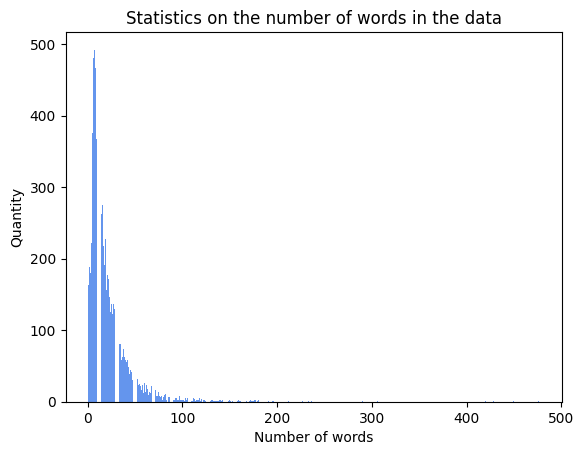

In [ ]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data
file_paths = ['data/reviews_data.csv', 'data/comment_train.csv']
x_data, y_data = prepare_data(file_paths)
x_data, y_data = prepare_data()
print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pickle

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open("C:/Users/nguye/Downloads/Vietnamese-Review-Classification/models/review_tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

(6000, 200)
(1500, 200)
(1500, 200)


In [ ]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

In [ ]:
import tensorflow as tf

tf.test.is_gpu_available()

True

In [103]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, SpatialDropout1D, Conv1D, MaxPooling1D
from keras import regularizers
import tensorflow as tf
import numpy as np
from keras.optimizers import Nadam
from keras.metrics import Precision, Recall


# Define individual RNN models
def build_rnn_model():
    model = Sequential()
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=200, input_length=max_len)
    model.add(embedding_layer)
 # Lấy tên của biến trong lớp nhúng
    new_embedding_name = 'embedding/embeddings:0'
    embedding_layer.weights[0]._name = new_embedding_name
    model.add(SpatialDropout1D(0.1))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=128)))
    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
    model.add(Dropout(rate=0.20))
    model.add(Dense(units=3, activation='softmax'))
    optimizer = Nadam(learning_rate=0.001)
    metrics = ['accuracy', Precision(), Recall()]
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)        
    return model

# Create ensemble of RNN models
ensemble_models = [build_rnn_model() for _ in range(10)]

# Lists to store minimum val_loss for each model
min_val_losses = []

# Train each individual model
for i, model in enumerate(ensemble_models):
    print(f"Training model {i+1}")
    # Define EarlyStopping callback to monitor val_loss
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.001, 
                                                  patience=3, 
                                                  restore_best_weights=True)
    # Train the model with EarlyStopping callback
    history = model.fit(x_train_pad, y_train_one_hot, batch_size=32, epochs=20, validation_data=(x_val_pad, y_val_one_hot), callbacks=[early_stopping])
    # Extract minimum val_loss from history and append to min_val_losses
    min_val_loss = min(history.history['val_loss'])
    min_val_losses.append(min_val_loss)
    print("Minimum val_loss for model", i+1, ":", min_val_loss)

# Print minimum val_loss across all models
print("Minimum val_loss across all models:", min(min_val_losses))
best_model_index = min_val_losses.index(min(min_val_losses))

# Lấy mô hình tương ứng từ ensemble_models
best_model = ensemble_models[best_model_index]

# Lấy history của mô hình
best_history = best_model.history
# lưu model tốt nhất
best_model.save("C:/Users/nguye/Downloads/Vietnamese-Review-Classification/models/review_model.keras")

Training model 1
Epoch 1/20
188/188 [==============================] - 10s 33ms/step - loss: 0.7821 - accuracy: 0.6738 - precision_38: 0.7871 - recall_38: 0.4850 - val_loss: 0.5403 - val_accuracy: 0.8007 - val_precision_38: 0.8414 - val_recall_38: 0.7640
Epoch 2/20
188/188 [==============================] - 6s 29ms/step - loss: 0.5066 - accuracy: 0.8160 - precision_38: 0.8651 - recall_38: 0.7672 - val_loss: 0.5229 - val_accuracy: 0.8080 - val_precision_38: 0.8517 - val_recall_38: 0.7773
Epoch 3/20
188/188 [==============================] - 6s 29ms/step - loss: 0.3872 - accuracy: 0.8505 - precision_38: 0.9025 - recall_38: 0.8118 - val_loss: 0.6578 - val_accuracy: 0.7653 - val_precision_38: 0.8299 - val_recall_38: 0.6927
Epoch 4/20
188/188 [==============================] - 6s 32ms/step - loss: 0.3175 - accuracy: 0.8868 - precision_38: 0.9169 - recall_38: 0.8457 - val_loss: 0.5566 - val_accuracy: 0.8000 - val_precision_38: 0.8294 - val_recall_38: 0.7747
Epoch 5/20
188/188 [==============

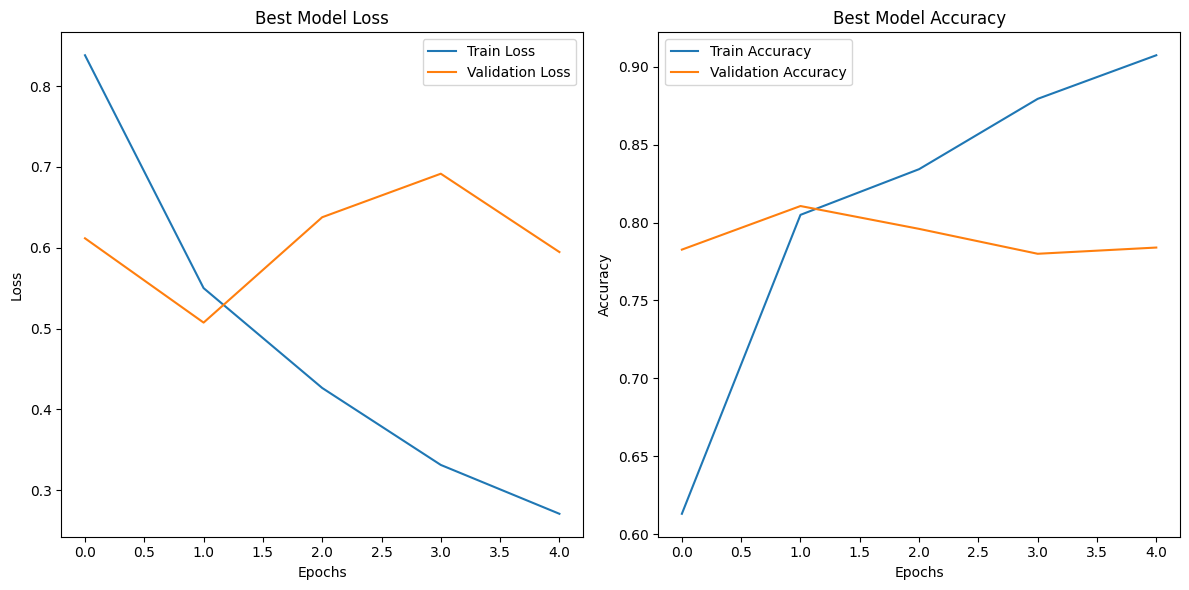

In [ ]:
import matplotlib.pyplot as plt

# Tìm chỉ số của mô hình có val_loss nhỏ nhất


# Vẽ biểu đồ cho mô hình có val_loss nhỏ nhất
plt.figure(figsize=(12, 6))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix

results = best_model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test results:', results)



y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

100/100 - 1s - loss: 0.4860 - accuracy: 0.8120 - precision_14: 0.8479 - recall_14: 0.7913 - 789ms/epoch - 8ms/step
Test results: [0.485989511013031, 0.8119999766349792, 0.8478571176528931, 0.7913333177566528]
100/100 [==============================] - 1s 7ms/step
Confusion Matrix:
[[774  27   0]
 [ 57 446   0]
 [101  95   0]]
